# Exploratory Analysis of RED FLAGS for contract integrity
Rule 1: Non-public bid opening (tender/procurementMethod)

In [2]:
# import libraries
import json
import pandas as pd
import matplotlib.pyplot as plt
import folium
import gc
from pandas import DataFrame

In [ ]:
#Read original CSV files to extract required data fields (procurement method, amount, buyer, region, cycle)
l = [i for i in range(1,14)]
for n in l:
    s="c"+str(n)+".csv"
    data=pd.read_csv(s)
    contratos=data[['releases']]
    
    a=[]#list of contract amounts
    b=[]#list of buyers
    c=[]#list of regions
    d=[]#List of cycles
    
    #Read json to extract data fields in contratos
    for n in contratos.iterrows():
        cifra=json.loads(n[1]["releases"])
        amount=0
        buyer=""
        region=""
        cycle=""
        
        #Get cycle
        try:
            cycle=cifra[0]["cycle"] 
        except:
            cycle=cifra[0]["ciclo"]
        
        #Get sum of amounts
        try:
            for m in cifra[0]["contracts"]:
                amount=amount+(m["value"]["amount"])
        except:
            amount=0
        
        for m in cifra[0]["parties"]:
            
            #Get buyer
            try:
                if m["roles"][0]=="buyer":
                    buyer=m["name"]
            except:
                     buyer=""                
            
            #Get region
            try:
                if m["roles"][0]=="procuringEntity":
                    region=m["address"]["region"]
            except:
                region=""
                
        a.append(amount)
        b.append(buyer)
        c.append(region)
        d.append(cycle)
        
    tenderers=data[["ocid","compiledRelease.tender.procurementMethod",'compiledRelease.buyer.name','compiledRelease.tender.value.amount']]
    tenderers['amount0'] = a
    tenderers['procuringEntity'] = b
    tenderers['region'] = c
    tenderers['cycle'] = d
    
    #Appending dataframe to a new CSV
    tenderers.to_csv("procurementMethod2.csv", header=False, mode = 'a')           
                
        a.append(amount)
        b.append(buyer)
        c.append(region)
        d.append(cycle)
        
    tenderers=data[["ocid","compiledRelease.tender.procurementMethod",'compiledRelease.buyer.name','compiledRelease.tender.value.amount']]
    tenderers['amount0'] = a
    tenderers['procuringEntity'] = b
    tenderers['region'] = c
    tenderers['cycle'] = d
    
    #Appending result to a new CSV
    #Remove , and rowsIDs later
    tenderers.to_csv("procurementMethod2.csv", header=False, mode = 'a')
    
# Destroy unused objects
del a,b,c,d,amount,buyer,region,cycle,tenderers
# Run garbage collection process 
gc.collect()

In [13]:
#Read new file
data=pd.read_csv("procurementMethod2.csv", encoding ='latin1', header=None,skiprows=[0])
data=data.rename(columns={0:'ocid', 1:'procurementMethod', 2:'buyer1', 3:'amount0', 4:'amount1', 5:'buyer2', 6:'region', 7:'cycle'})

#Define function to identify finalAmount
def f(row):
    if row['amount0'] > row['amount1']:
        val = row['amount0']
    else:
        val = row['amount1']
    return val

#Apply function to dataframe
data['finalAmount'] = data.apply(f, axis=1)

#Label unknown procurement methods
#mask = data.procurementMethod == "0"
#column_name = 'procurementMethod'
data.loc[data.procurementMethod == "0", 'procurementMethod'] = "unknown"
data.loc[data.buyer2 == "0", 'buyer2'] = "unknown"
data.loc[data.region == "0", 'region'] = "unknown"

In [14]:
data.head()

,ocid,procurementMethod,buyer1,amount0,amount1,buyer2,region,cycle,finalAmount
0,ocds-07smqs-1072,unknown,0,0.0,0.0,delegación SEDESOL en Tabasco,unknown,2017,0.0
1,ocds-07smqs-1111,unknown,0,0.0,0.0,delegación SEDESOL en México,unknown,2017,0.0
2,ocds-07smqs-1117,unknown,0,0.0,0.0,Instituto Nacional de Antropología e Historia,unknown,2017,0.0
3,ocds-07smqs-1182,unknown,0,0.0,0.0,Servicio de Administración Tributaria,unknown,2017,0.0
4,ocds-07smqs-1191,unknown,0,0.0,0.0,delegación SEDESOL en Tabasco,unknown,2017,0.0


procurementMethod  direct   open  selective  unknown
cycle                                               
2015                   15      0          0        0
2016                 1102     11          4        0
2017               132324  11596      12568     4457
2018               117137   8785       8735     3530


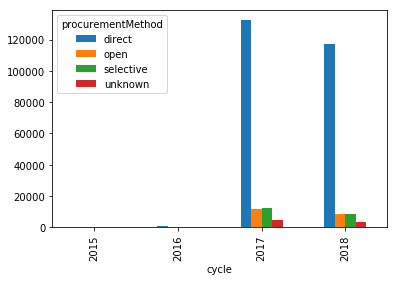

In [15]:
#Create pivot table with the count of contracts by year and procurementMethod
year=data.groupby(['cycle','procurementMethod'])['procurementMethod'].aggregate('count').unstack()
print(year.fillna(0).astype(int))

#Plot pivot table
year.plot(kind='bar')
plt.show()

Most of the contracts correspond to the years 2017 and 2018. Direct contracting is the preferred method.

procurementMethod  direct  open  selective  unknown
cycle                                              
2015                  100     0          0        0
2016                   98     0          0        0
2017                   82     7          7        2
2018                   84     6          6        2


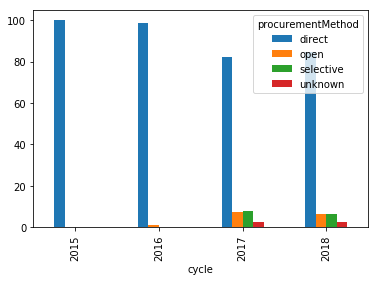

In [16]:
#Create pivot table with the count of contracts by year and procurementMethod
year=data.groupby(['cycle','procurementMethod'])['procurementMethod'].aggregate('count')
year_pcts = year.groupby(level=0).apply(lambda x:
                                                 100 * x / float(x.sum())).unstack()
print(year_pcts.fillna(0).astype(int))

#Plot pivot table
year_pcts.plot(kind='bar')
plt.show()

For all years more than 80% of the contracts are assigned directly.

In [17]:
#Create pivot table with the count of contracts by year and procurementMethod
region=data.groupby(['region','procurementMethod'])['procurementMethod'].aggregate('count')
region_pcts =region.groupby(level=0).apply(lambda x:
                                                 100 * x / float(x.sum())).unstack()

a=DataFrame(region_pcts.fillna(0).astype(int).to_records())
a=a[a.region!="unknown"].sort_values(by='direct', ascending=False)
print(a)

                 region  direct  open  selective  unknown
6      Ciudad de Mexico      90     3          5        0
10           Guanajuato      86     8          5        0
13              Jalisco      86     5          8        0
7              Coahuila      85    10          4        0
25               Sonora      84     7          7        0
1       Baja California      83    14          2        0
15            Michoacan      82     8          9        0
21            Queretaro      82     9          8        0
12              Hidalgo      81     9          9        0
2   Baja California Sur      81    10          8        0
30              Yucatan      80    12          6        0
20               Puebla      80     8         10        0
5             Chihuahua      79    12          7        0
18           Nuevo Leon      77    12          9        0
17              Nayarit      77    16          5        0
16              Morelos      77    17          5        0
14            

In [18]:
#https://gist.github.com/ponentesincausa/46d1d9a94ca04a56f93d#file-mexico-json
mexicoGeo = r'mexico.json' # geojson file

# create a plain mexican map
mexico_map = folium.Map(location=[24,-103], zoom_start=5) #tiles='Mapbox Bright'

# generate choropleth map using the total % of direct contracts by state
folium.Choropleth(
    geo_data=mexicoGeo,
    data=a,
    columns=['region', 'direct'],
    key_on='feature.properties.name',
    fill_color='YlGn', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='% of direct contracts by state'
).add_to(mexico_map)

# display map
mexico_map

procurementMethod  direct  open  selective  unknown
cycle                                              
2015                    5     0          0        0
2016                  200     5          0        0
2017                 8426  7036       5362        2
2018                 7836  5441       4227        2


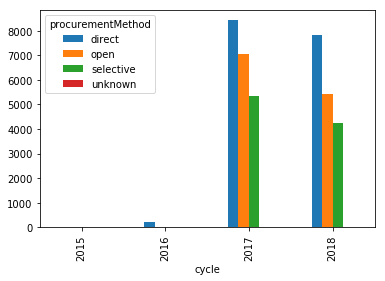

In [19]:
#Create pivot table with the count of contracts by year and procurementMethod for high value contracts
year=data.loc[data['finalAmount'] >= 1000000].groupby(['cycle','procurementMethod'])['procurementMethod'].aggregate('count').unstack()
print(year.fillna(0).astype(int))

#Plot pivot table
year.plot(kind='bar')
plt.show()

In the case of high value contracts (amount>= 1000000) the number of open contracts is subtantially higher

procurementMethod  direct  open  selective  unknown
cycle                                              
2015                  100     0          0        0
2016                   97     2          0        0
2017                   40    33         25        0
2018                   44    31         24        0


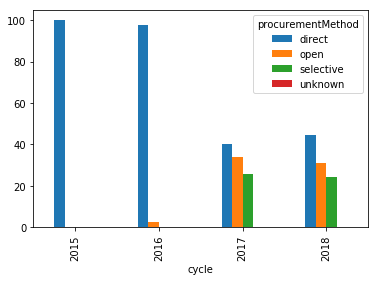

In [20]:
#Create pivot table with the count of contracts by year and procurementMethod
year=data.loc[data['finalAmount'] >= 1000000].groupby(['cycle','procurementMethod'])['procurementMethod'].aggregate('count')
year_pcts = year.groupby(level=0).apply(lambda x:
                                                 100 * x / float(x.sum())).unstack()
print(year_pcts.fillna(0).astype(int))

#Plot pivot table
year_pcts.plot(kind='bar')
plt.show()

For high value contracts the proportion of direct contracts is around 40% in 2017 and 2018

In [21]:
#Create pivot table with the count of contracts by year and procurementMethod
region=data.loc[data['finalAmount'] >= 1000000].groupby(['region','procurementMethod'])['procurementMethod'].aggregate('count')
region_pcts =region.groupby(level=0).apply(lambda x:
                                                 100 * x / float(x.sum())).unstack()

a=DataFrame(region_pcts.fillna(0).astype(int).to_records())
a=a[a.region!="unknown"].sort_values(by='direct', ascending=False)
print(a)

                 region  direct  open  selective  unknown
6      Ciudad de Mexico      53    23         22        0
25               Sonora      46    35         18        0
14               Mexico      44    34         20        0
1       Baja California      41    52          6        0
7              Coahuila      40    52          6        0
2   Baja California Sur      37    41         20        0
10           Guanajuato      36    36         26        0
19               Oaxaca      36    42         21        0
12              Hidalgo      35    38         25        0
18           Nuevo Leon      34    42         22        0
24              Sinaloa      33    44         21        0
13              Jalisco      33    33         33        0
5             Chihuahua      32    40         26        0
15            Michoacan      31    35         32        0
20               Puebla      31    42         26        0
4               Chiapas      31    35         32        0
30            

In [23]:
#https://gist.github.com/ponentesincausa/46d1d9a94ca04a56f93d#file-mexico-json
mexicoGeo = r'mexico.json' # geojson file

# create a plain mexican map
mexico_map = folium.Map(location=[24,-103], zoom_start=5) #tiles='Mapbox Bright'

# generate choropleth map using the total % of direct contracts by state
folium.Choropleth(
    geo_data=mexicoGeo,
    data=a,
    columns=['region', 'direct'],
    key_on='feature.properties.name',
    fill_color='YlGn', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='% of direct contracts by state >= 1,000,000 pesos'
).add_to(mexico_map)

# display map
mexico_map